## Modelo Baseline

### 1.0 Importando as Libs

In [1]:
import sys
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

### 2.0 Carregando o dataset

In [2]:
prices_df = pd.read_csv("../data/processed/model_df.csv", sep=',', encoding='latin1')

#### 3.1 Train Test Split

In [29]:
X, y = prices_df.drop("Price_euros", axis=1), prices_df["Price_euros"]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [31]:
feature_scaler = StandardScaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)
X_val = feature_scaler.transform(X_val)

#### 3.2 Train the model

In [32]:
model = XGBRegressor(eval_metric=["mae", "logloss"])
model = model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=0
)

In [33]:
# predict on the validation set
predictions = model.predict(X_test)

# Get evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

# Score the model
model.score(X_test, y_test)

# test_df = pd.DataFrame(X_test)
# test_df['Actuals'] = y_test
# test_df['Predictions'] = predictions

0.8166250321282249

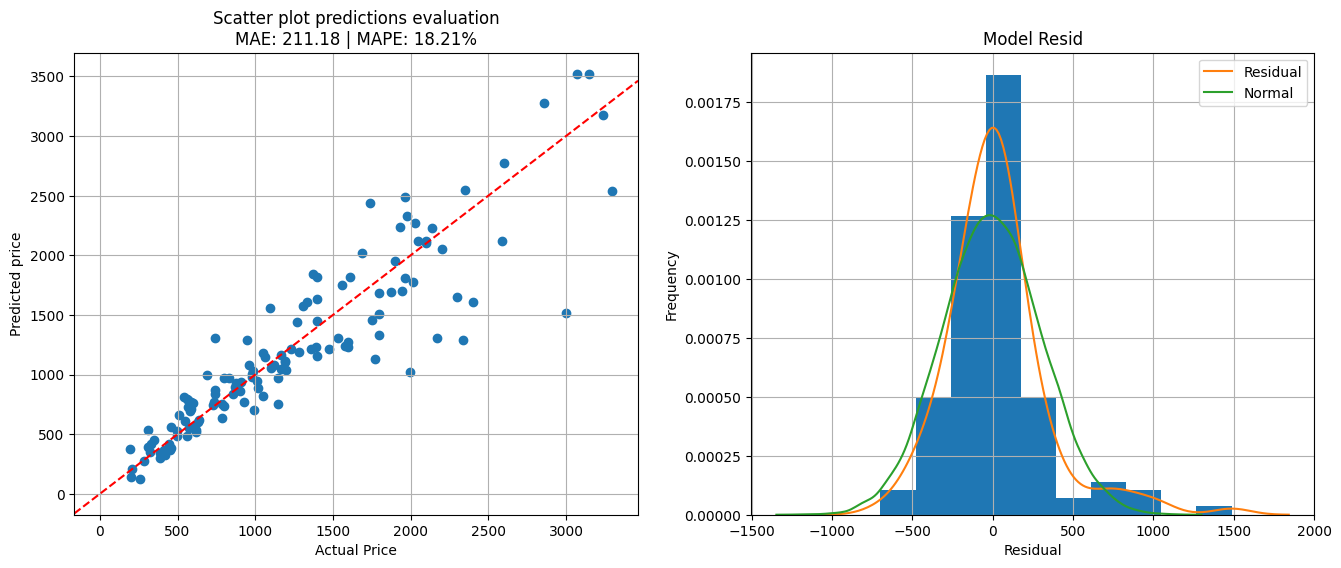

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot diagonal line
axs[0].axline((1,1), slope=1, color='r', ls='--')
# Scatter predictions vs true
axs[0].scatter(x=y_test, y=predictions)
axs[0].set_title(f"Scatter plot predictions evaluation\nMAE: {round(mae, 2)} | MAPE: {round(mape, 4)*100}%")
axs[0].set_xlabel("Actual Price")
axs[0].set_ylabel("Predicted price")
axs[0].grid()

# Plot the Residuals
residuals = y_test - predictions
axs[1].hist(residuals, density=True)
axs[1].set_title("Model Resid")
axs[1].set_xlabel("Residual")
axs[1].set_ylabel("Frequency")
sns.kdeplot(residuals, label='Residual')
s = np.random.normal(0, np.std(residuals), 10000)
sns.kdeplot(s, label='Normal')

axs[1].grid()
plt.legend()
plt.show()

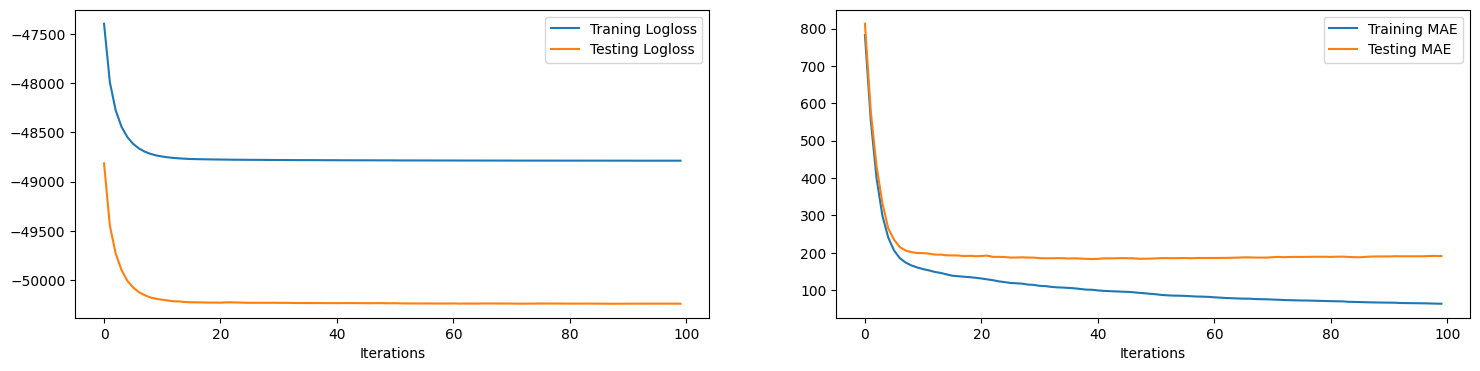

In [39]:
# plot learning curves
learning_results = model.evals_result()

fig, axs = plt.subplots(1, 2, figsize=(18, 4))
axs[0].plot(learning_results['validation_0']['logloss'], label='Traning Logloss')
axs[0].plot(learning_results['validation_1']['logloss'], label='Testing Logloss')

axs[1].plot(learning_results['validation_0']['mae'], label='Training MAE')
axs[1].plot(learning_results['validation_1']['mae'], label='Testing MAE')

axs[0].set_xlabel("Iterations")
axs[1].set_xlabel("Iterations")
# show the legend
axs[0].legend()
axs[1].legend()
# show the plot
plt.show()

### 3.3 Perform Hyperparameter Optimization

In [93]:
param_grid = {
        'min_child_weight': [10, 12, 15, 20, None],
        'gamma': [0.05, 0.1, 0.25, 0.5, None],
        'subsample': [0.6, 0.8, 1.0, None],
        'colsample_bytree': [0.8, 1.0, None],
        'max_depth': [7, 10, 13, None],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, None],
        'n_estimators': [40, 100, 200, None],
        'reg_lambda': [1, 5, 10, None]
}

In [94]:
gridsearcher = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid = param_grid,
    scoring='neg_mean_squared_error',
    cv=4,
    verbose=2,
    n_jobs=8
)

gridsearcher = gridsearcher.fit(X_train, y_train)

Fitting 5 folds for each of 96000 candidates, totalling 480000 fits


KeyboardInterrupt: 

In [78]:
print('\n Best hyperparameters:')
print(gridsearcher.best_params_)
results = pd.DataFrame(gridsearcher.cv_results_)

Fitting 5 folds for each of 24000 candidates, totalling 120000 fits


/home/michel/.laptop_price/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30000 fits failed out of a total of 120000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30000 fits failed with the following error:
Traceback (most recent call last):
  File "/home/michel/.laptop_price/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/michel/.laptop_price/lib/python3.9/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/home/michel/.laptop_price/lib/python3.9/site-packages/xgboost/sklearn.py", line 1025, in fit
    self._Booster = train(
  File "/home/miche

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=8,
             param_grid={'colsample_bytree': [0.8, 1.0, None],
                         'gamma': [0.1, 0.25, 0.5, 1, None],
                         'learning_rate': [0.05, 0.1, 0.2, 0.5, None],
                         'max_depth': [5, 7, 10, None],
                         'min_child_weight': [10, 12, 15, 20, None],
                         'n_estimators': [40, 100, 200, None],
                         'subsample': [0.6, 0.8, 1.0, None]},
             scoring='neg_mean_squared_error', verbose=1)

In [79]:
results.head()


 Best hyperparameters:
{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': None, 'n_estimators': 100, 'subsample': 0.6}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.081558,0.003912,0.004264,0.001615,0.8,0.1,0.05,5,10,40,0.6,"{'colsample_bytree': 0.8, 'gamma': 0.1, 'learn...",-208791.692520,-100370.321052,-174279.557026,-156223.796909,-162954.934334,-160524.060368,35105.132871,17476
1,0.079458,0.009726,0.004092,0.000724,0.8,0.1,0.05,5,10,40,0.8,"{'colsample_bytree': 0.8, 'gamma': 0.1, 'learn...",-192135.661192,-96207.760908,-174469.388277,-148233.177428,-152767.967546,-152762.791070,32374.027019,17266
2,0.064694,0.003113,0.002895,0.000112,0.8,0.1,0.05,5,10,40,1.0,"{'colsample_bytree': 0.8, 'gamma': 0.1, 'learn...",-185776.870855,-101980.833709,-170231.072561,-150151.987998,-148486.357680,-151325.424561,28244.120020,17196
3,0.078254,0.008281,0.004100,0.001361,0.8,0.1,0.05,5,10,40,None,"{'colsample_bytree': 0.8, 'gamma': 0.1, 'learn...",-185776.870855,-101980.833709,-170231.072561,-150151.987998,-148486.357680,-151325.424561,28244.120020,17196
4,0.207091,0.019428,0.003877,0.000977,0.8,0.1,0.05,5,10,100,0.6,"{'colsample_bytree': 0.8, 'gamma': 0.1, 'learn...",-139298.304663,-93826.274174,-98245.546955,-96730.261617,-105847.962460,-106789.669974,16732.850969,8407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,0.280758,0.055967,0.002401,0.000294,None,None,None,None,None,200,None,"{'colsample_bytree': None, 'gamma': None, 'lea...",-103331.635889,-126671.488457,-87379.908605,-113924.173775,-101740.430380,-106609.527421,13116.533464,8367
23996,0.002271,0.000193,0.000000,0.000000,None,None,None,None,None,None,0.6,"{'colsample_bytree': None, 'gamma': None, 'lea...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,18001
23997,0.002744,0.000735,0.000000,0.000000,None,None,None,None,None,None,0.8,"{'colsample_bytree': None, 'gamma': None, 'lea...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,18001
23998,0.002421,0.000053,0.000000,0.000000,None,None,None,None,None,None,1.0,"{'colsample_bytree': None, 'gamma': None, 'lea...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,18001


In [81]:
print('\n Best estimator:')
print(gridsearcher.best_estimator_)


 Best estimator:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


In [86]:
model = XGBRegressor(**{'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 10, 'n_estimators': 200, 'subsample': 1.0}, eval_metric=["mae", "logloss"])
model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)]
)

[0]	validation_0-mae:1054.40840	validation_0-logloss:-45416.56816	validation_1-mae:1086.14892	validation_1-logloss:-46783.98489
[1]	validation_0-mae:1002.83333	validation_0-logloss:-46152.96097	validation_1-mae:1033.72196	validation_1-logloss:-47542.14130
[2]	validation_0-mae:953.77036	validation_0-logloss:-46573.94559	validation_1-mae:983.83415	validation_1-logloss:-47975.43590
[3]	validation_0-mae:907.13576	validation_0-logloss:-46865.12516	validation_1-mae:936.31502	validation_1-logloss:-48275.68754
[4]	validation_0-mae:862.79759	validation_0-logloss:-47085.94347	validation_1-mae:892.35250	validation_1-logloss:-48499.11043
[5]	validation_0-mae:820.81285	validation_0-logloss:-47261.08128	validation_1-mae:851.50038	validation_1-logloss:-48673.21988
[6]	validation_0-mae:780.94934	validation_0-logloss:-47405.52059	validation_1-mae:812.37275	validation_1-logloss:-48818.96695
[7]	validation_0-mae:743.00750	validation_0-logloss:-47527.89207	validation_1-mae:773.50875	validation_1-logloss:-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['mae', 'logloss'],
             feature_types=None, gamma=0.1, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=10, missing=nan,
             monotone_constraints=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

In [87]:
# predict on the validation set
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
model.score(X_test, y_test)

0.8502305393305934

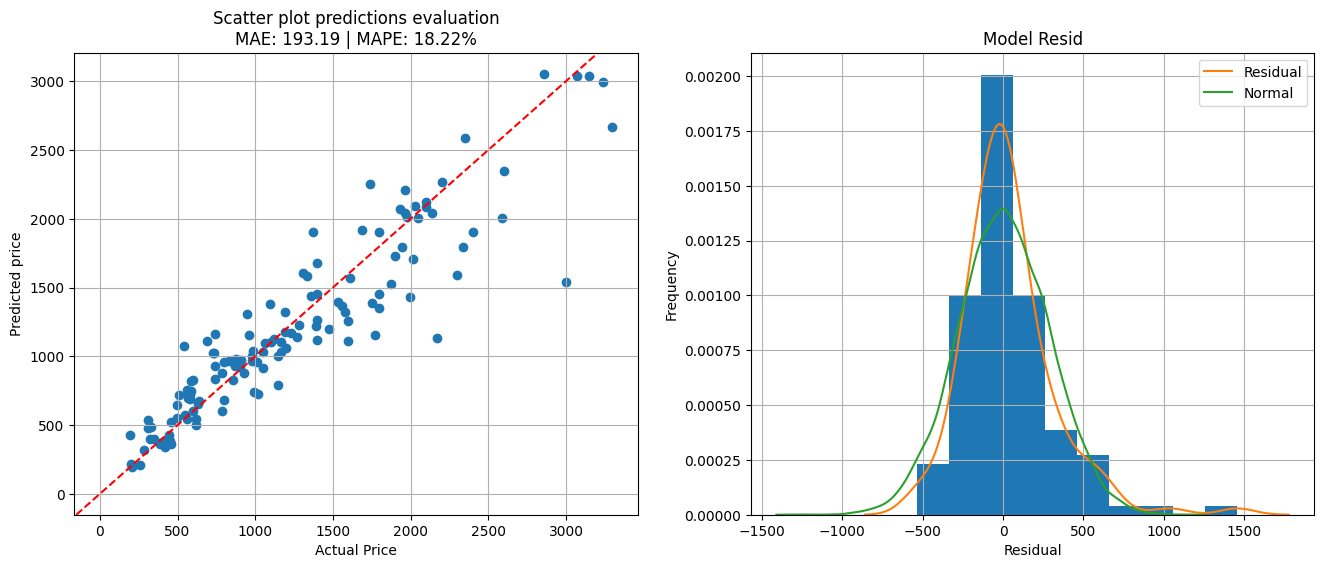

In [88]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot diagonal line
axs[0].axline((1,1), slope=1, color='r', ls='--')
# Scatter predictions vs true
axs[0].scatter(x=y_test, y=predictions)
axs[0].set_title(f"Scatter plot predictions evaluation\nMAE: {round(mae, 2)} | MAPE: {round(mape, 4)*100}%")
axs[0].set_xlabel("Actual Price")
axs[0].set_ylabel("Predicted price")
axs[0].grid()

# Plot the Residuals
residuals = y_test - predictions
axs[1].hist(residuals, density=True)
axs[1].set_title("Model Resid")
axs[1].set_xlabel("Residual")
axs[1].set_ylabel("Frequency")
sns.kdeplot(residuals, label='Residual')
s = np.random.normal(0, np.std(residuals), 10000)
sns.kdeplot(s, label='Normal')

axs[1].grid()
plt.legend()
plt.show()

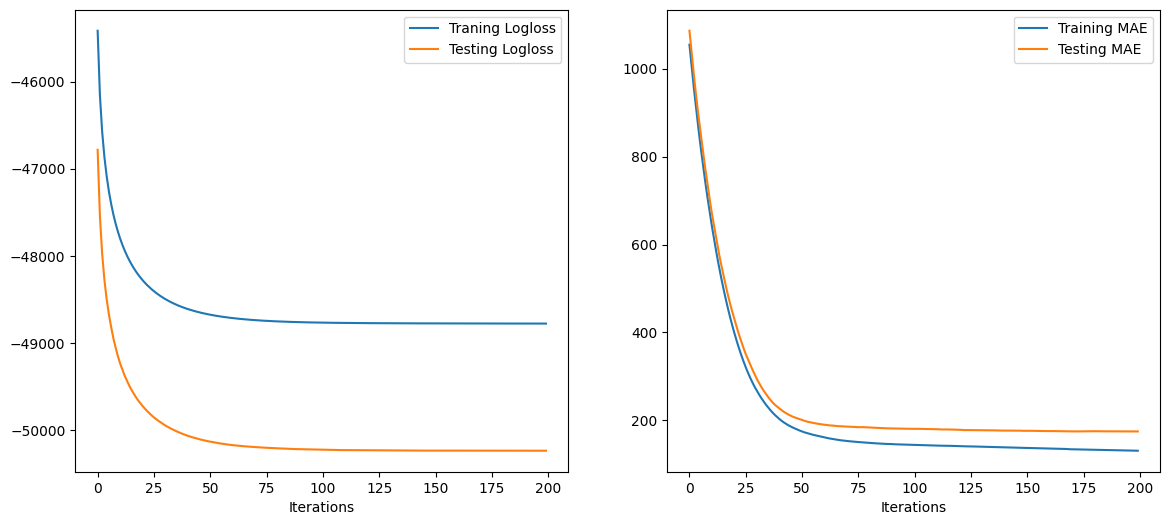

In [89]:
# plot learning curves
learning_results = model.evals_result()

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].plot(learning_results['validation_0']['logloss'], label='Traning Logloss')
axs[0].plot(learning_results['validation_1']['logloss'], label='Testing Logloss')

axs[1].plot(learning_results['validation_0']['mae'], label='Training MAE')
axs[1].plot(learning_results['validation_1']['mae'], label='Testing MAE')

axs[0].set_xlabel("Iterations")
axs[1].set_xlabel("Iterations")
# show the legend
axs[0].legend()
axs[1].legend()
# show the plot
plt.show()